In [2]:

import os
import glob
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F

from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint, TerminateOnNan
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import Loss, Accuracy, Precision, Recall

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, 
                             precision_score, recall_score, f1_score, roc_curve, auc)

In [3]:
torch.manual_seed(42)
record_path=r"C:\Users\piotr\.cache\kagglehub\datasets\nih-chest-xrays\data\versions\3"

In [4]:
# cleaning the dataframe
df=pd.read_csv(record_path+r"\Data_Entry_2017.csv")
good=["Image Index","Finding Labels"]
df=df[good]
display(df)

,Image Index,Finding Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_000.png,Hernia
...,...,...
112115,00030801_001.png,Mass|Pneumonia
112116,00030802_000.png,No Finding
112117,00030803_000.png,No Finding
112118,00030804_000.png,No Finding


In [5]:
# Getting all the deseases from the DF and creating one-hot encoding.
diseases=set()
for findings in df["Finding Labels"].unique():
    for disease_label in findings.split("|"):
        diseases.add(disease_label)
print(diseases)
for d in diseases:
    df[d]=0
for index,row in df.iterrows():
    labels= row["Finding Labels"].split("|")
    for i in labels:
        df.loc[index,i]=1
df=df.drop("Finding Labels",axis=1)
display(df)

{'Pleural_Thickening', 'Effusion', 'Nodule', 'Hernia', 'Pneumothorax', 'Pneumonia', 'Cardiomegaly', 'No Finding', 'Fibrosis', 'Edema', 'Consolidation', 'Atelectasis', 'Mass', 'Infiltration', 'Emphysema'}


,Image Index,Pleural_Thickening,Effusion,Nodule,Hernia,Pneumothorax,Pneumonia,Cardiomegaly,No Finding,Fibrosis,Edema,Consolidation,Atelectasis,Mass,Infiltration,Emphysema
0,00000001_000.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,00000001_001.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,00000001_002.png,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,00000003_000.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


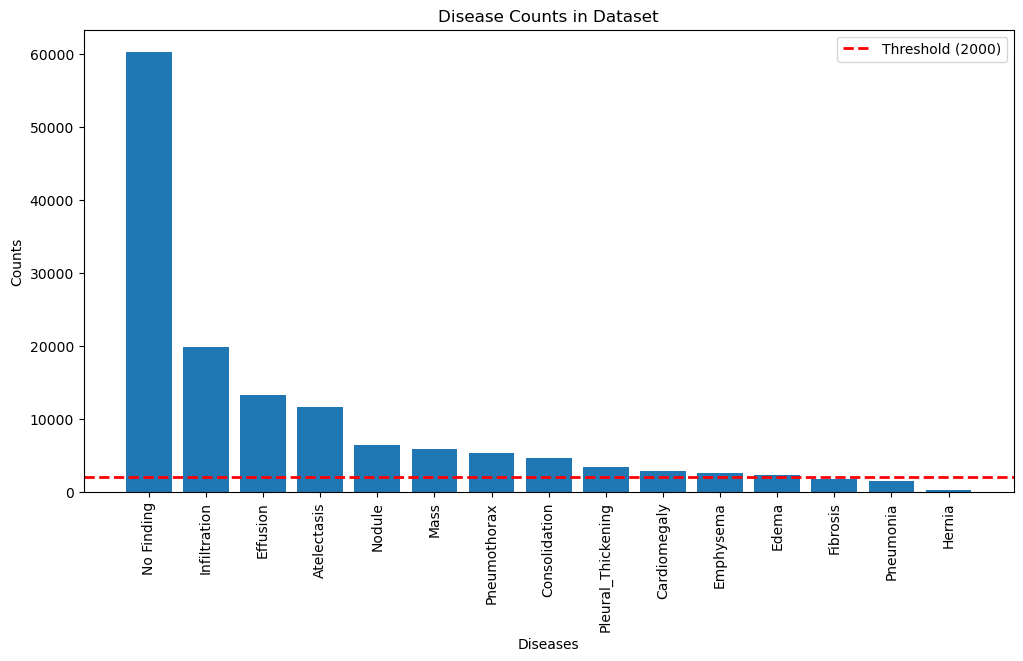

In [6]:
counts=[df[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [7]:
# # we now create the training data frame using the list provided in the files.
# image_names_train= open(r"train_val_list.txt").read().split("\n")
# for i in image_names_train:
#     df_train=df[df["Image Index"].isin(image_names_train)]
# df_train.to_parquet("df_train.parquet")

In [8]:
# # we now create the training data frame using the list provided in the files.
# image_names_test= open(r"test_list.txt").read().split("\n")
# for i in image_names_test:
#     df_test=df[df["Image Index"].isin(image_names_test)]
# df_test.to_parquet("df_test.parquet")

In [9]:
df_train=pd.read_parquet("df_train.parquet")

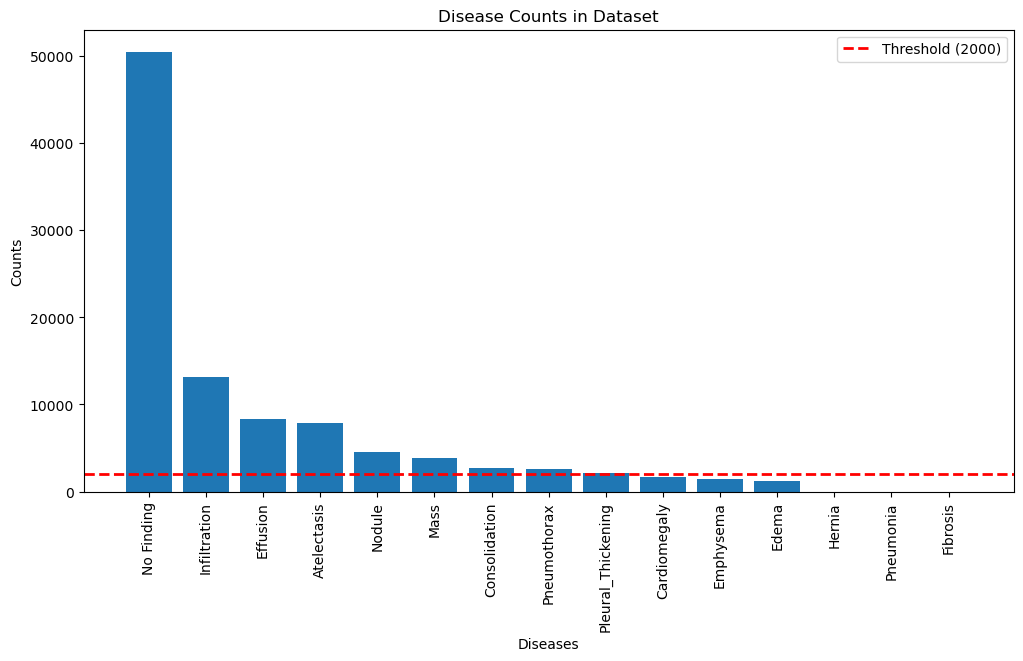

In [10]:
# We check to see how balanced the set is and check if any class is very underrepresented.
diseases=list(diseases)
counts=[df_train[d].sum() for d in diseases]
disease_counts = sorted(zip(diseases, counts), key=lambda x: x[1], reverse=True)
sorted_diseases, sorted_counts = zip(*disease_counts)

plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_diseases, sorted_counts)
plt.axhline(y=2000, color='red', linestyle='--', linewidth=2, label='Threshold (2000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [11]:
# we remove diseases that are too rare.
rare_diseases=[d[0] for d in disease_counts if d[1]<2000]
print("Rare Diseases ( <2000 images ): ", rare_diseases)
for disease in rare_diseases:
    df_train=df_train[df_train[disease] !=1]


Rare Diseases ( <2000 images ):  ['Cardiomegaly', 'Emphysema', 'Edema', 'Hernia', 'Pneumonia', 'Fibrosis']


In [12]:
df_train=df_train[["Image Index"]+[i for i in diseases if i not in rare_diseases]]

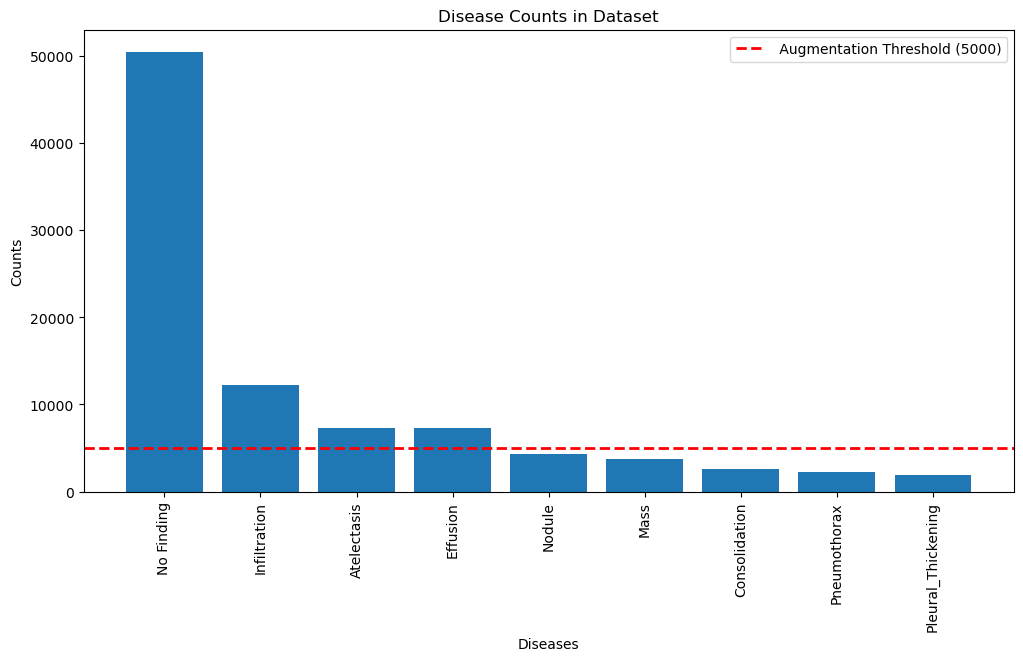

In [13]:
# We check to see how balanced the set is and check if any class is very underrepresented.
common_diseases=[i for i in diseases if i not in rare_diseases]
common_counts=[df_train[i].sum() for i in common_diseases if i in df_train.columns]
common_disease_counts = sorted(zip(common_diseases, common_counts), key=lambda x: x[1], reverse=True)
sorted_common_diseases, sorted_common_counts = zip(*common_disease_counts)
plt.figure(figsize=(12, 6))  # Adjust figure size for readability
plt.bar(sorted_common_diseases, sorted_common_counts)
plt.axhline(y=5000, color='red', linestyle='--', linewidth=2, label=' Augmentation Threshold (5000)')
plt.xticks(rotation=90, ha='center')
plt.xlabel('Diseases')
plt.ylabel('Counts')
plt.title('Disease Counts in Dataset')
plt.legend()
plt.show()

In [14]:
df_train=df_train.drop(columns=["No Finding"])

In [15]:
image_paths=glob.glob(record_path+r"\**\*.png",recursive=True)

In [16]:
image_path_dict = {path.split("\\")[-1]: path for path in image_paths}

class XrayDataset(Dataset):
    def __init__(self, df, image_path_dict, transform=None):
        self.df = df
        self.image_path_dict = image_path_dict  # Dictionary for quick lookup
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df.iloc[idx]['Image Index']
        image_path = self.image_path_dict[image_name]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.df.iloc[idx].iloc[1:].values.astype(float)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

#Data Augmentation transform
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((224, 224)),
    v2.RandomAffine(degrees=5, translate=(0.02, 0.02), scale=(0.95, 1.05), shear=5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.ColorJitter(brightness=0.1, contrast=0.1),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [17]:

# Split the training dataset into train and validation sets (80% train, 20% validation)
train_df, val_df = train_test_split(df_train, test_size=0.2, random_state=42)
# Create new datasets for training and validation
train_dataset = XrayDataset(train_df, image_path_dict, transform=transform)
val_dataset = XrayDataset(val_df, image_path_dict, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,pin_memory=True)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Count how many classes remain after dropping rare diseases
num_classes = len([d for d in common_diseases if d != "No Finding"])
print("Number of classes:", num_classes)
class LSEPoolingHead(nn.Module):
    """
    Custom head to incorporate LSE pooling between 
    the final feature map and the output layer.
    """
    def __init__(self, in_features, num_classes, r=10.0):
        super().__init__()
        self.r = r
        self.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        # Expecting x shape = (batch, C, H, W)
        # 1) LSE pooling
        b, c, h, w = x.shape
        x_2d = x.view(b, c, -1)  # shape: (batch, C, H*W)

        # For numerical stability, subtract the max along the spatial dim
        x_max, _ = x_2d.max(dim=2, keepdim=True)  # shape: (batch, C, 1)
        x_stable = x_2d - x_max

        # LSE formula
        out = (1.0 / self.r) * torch.log(
            1e-6 + torch.mean(torch.exp(self.r * x_stable), dim=2)
        ) + x_max.squeeze(2)  # shape: (batch, C)

        # 2) Final linear layer to get (batch, num_classes)
        logits = self.classifier(out)
        return logits

class DenseNetWithLSE(nn.Module):
    """
    Wraps a DenseNet-121, but removes its adaptive avg pool and 
    built-in classifier. Instead, we apply ReLU + LSEPoolingHead.
    """
    def __init__(self, num_classes=8, r=10.0, freeze_until='denseblock4'):
        super().__init__()
        # Load the pretrained DenseNet
        base_net = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # Freeze some parts if desired
        for name, param in base_net.features.named_parameters():
            # Example: freeze all layers except the last denseblock
            if freeze_until in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # We'll keep the feature extractor, but skip the classifier
        self.features = base_net.features
        # We'll remove the built-in classifier to do custom pooling
        # Original: out = F.adaptive_avg_pool2d(out, (1, 1))
        # We'll override the forward to skip that

        # Build custom LSE head
        # DenseNet-121 final channels = 1024
        self.lse_head = LSEPoolingHead(
            in_features=1024, 
            num_classes=num_classes, 
            r=r
        )

    def forward(self, x):
        # 1) Pass input through the DenseNet feature layers
        out = self.features(x)                     # shape: (batch, 1024, H, W)
        out = F.relu(out, inplace=True)            # shape: (batch, 1024, H, W)
        # 2) Instead of adaptive pooling, do LSE pooling
        logits = self.lse_head(out)
        return logits
    
# We start with DenseNet121
model = DenseNetWithLSE(
    num_classes=num_classes, 
    r=10.0,                 # hyperparameter for LSE
    freeze_until='denseblock4'  # or adjust as you want
)
model = model.to(device)

# Loss function and optimizer
pos_weight = (df_train.iloc[:,1:]==0.).sum()/df_train.iloc[:,1:].sum()
class_weights=torch.tensor(pos_weight.values,dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
# Create the trainer and evaluators
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)

val_metrics = {
    "accuracy": Accuracy(output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "precision": Precision(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "recall": Recall(average=False, output_transform=lambda x: (torch.sigmoid(x[0]) > 0.5, x[1]), is_multilabel=True),
    "loss": Loss(criterion)
}

train_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

# Attach progress bar to the trainer
pbar = ProgressBar(persist=True)
pbar.attach(trainer, output_transform=lambda x: {"loss": x})

# Validation after each epoch
@trainer.on(Events.EPOCH_COMPLETED)
def run_validation(engine):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_loss = metrics['loss']
    print(f"\nValidation - Epoch: {engine.state.epoch} | "
          f"Avg accuracy: {avg_accuracy:.4f} | Avg loss: {avg_loss:.4f}")
@trainer.on(Events.EPOCH_COMPLETED)
def log_learning_rate(engine):
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Learning Rate after Epoch {engine.state.epoch}: {current_lr:.6f}")
@trainer.on(Events.EPOCH_COMPLETED)
def run_scheduler(engine):
    val_loss = val_evaluator.state.metrics["loss"]
    scheduler.step(val_loss)
    print(f"Scheduler stepped with validation loss: {val_loss:.4f}")
    
early_stopping = EarlyStopping(
    patience=5,  # Number of epochs to wait without improvement
    score_function=lambda engine: -engine.state.metrics["loss"],  # Use validation loss (negative for minimizing)
    trainer=trainer
)
val_evaluator.add_event_handler(Events.COMPLETED, early_stopping)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

checkpoint_handler = ModelCheckpoint(
    dirname='checkpoints',
    filename_prefix='chestxray',
    n_saved=1,
    create_dir=True,
    require_empty=False,
    score_function=lambda e: -e.state.metrics["loss"], 
    score_name="val_loss",
    global_step_transform=lambda e, _: e.state.epoch
)

val_evaluator.add_event_handler(Events.COMPLETED, checkpoint_handler, {
    'best_model': model
})

Using device: cuda
Number of classes: 8


c:\Users\piotr\anaconda3\Lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [20]:
model.load_state_dict(torch.load(r"C:\Users\piotr\Documents\GitHub\X-ray-disease-detection\checkpoints\chestxray_best_model_1_val_loss=-1.2650.pt", weights_only=True))

<All keys matched successfully>

In [ ]:
trainer.run(train_loader, max_epochs=100)

[1/4005]   0%|           [00:00<?]


Validation - Epoch: 4 | Avg accuracy: 0.2172 | Avg loss: 1.6017
Learning Rate after Epoch 4: 0.001000
Scheduler stepped with validation loss: 1.6017


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 5 | Avg accuracy: 0.1986 | Avg loss: 1.2388
Learning Rate after Epoch 5: 0.001000
Scheduler stepped with validation loss: 1.2388


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 6 | Avg accuracy: 0.2287 | Avg loss: 1.2138
Learning Rate after Epoch 6: 0.001000
Scheduler stepped with validation loss: 1.2138


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 7 | Avg accuracy: 0.3008 | Avg loss: 1.2874
Learning Rate after Epoch 7: 0.001000
Scheduler stepped with validation loss: 1.2874


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 8 | Avg accuracy: 0.1944 | Avg loss: 1.0705
Learning Rate after Epoch 8: 0.000100
Scheduler stepped with validation loss: 1.0705


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 9 | Avg accuracy: 0.2419 | Avg loss: 1.0497
Learning Rate after Epoch 9: 0.000100
Scheduler stepped with validation loss: 1.0497


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 10 | Avg accuracy: 0.2667 | Avg loss: 1.0427
Learning Rate after Epoch 10: 0.000100
Scheduler stepped with validation loss: 1.0427


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 11 | Avg accuracy: 0.1626 | Avg loss: 1.0553
Learning Rate after Epoch 11: 0.000100
Scheduler stepped with validation loss: 1.0553


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 12 | Avg accuracy: 0.2260 | Avg loss: 1.0622
Learning Rate after Epoch 12: 0.000100
Scheduler stepped with validation loss: 1.0622


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 13 | Avg accuracy: 0.2557 | Avg loss: 1.0553
Learning Rate after Epoch 13: 0.000100
Scheduler stepped with validation loss: 1.0553


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 14 | Avg accuracy: 0.2179 | Avg loss: 1.0487
Learning Rate after Epoch 14: 0.000100
Scheduler stepped with validation loss: 1.0487


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 15 | Avg accuracy: 0.2181 | Avg loss: 1.0344
Learning Rate after Epoch 15: 0.000010
Scheduler stepped with validation loss: 1.0344


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 16 | Avg accuracy: 0.2607 | Avg loss: 1.0347
Learning Rate after Epoch 16: 0.000010
Scheduler stepped with validation loss: 1.0347


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 17 | Avg accuracy: 0.2416 | Avg loss: 1.0585
Learning Rate after Epoch 17: 0.000010
Scheduler stepped with validation loss: 1.0585


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 18 | Avg accuracy: 0.2272 | Avg loss: 1.0310
Learning Rate after Epoch 18: 0.000010
Scheduler stepped with validation loss: 1.0310


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 19 | Avg accuracy: 0.2535 | Avg loss: 1.0375
Learning Rate after Epoch 19: 0.000010
Scheduler stepped with validation loss: 1.0375


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 20 | Avg accuracy: 0.2486 | Avg loss: 1.0393
Learning Rate after Epoch 20: 0.000010
Scheduler stepped with validation loss: 1.0393


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 21 | Avg accuracy: 0.2363 | Avg loss: 1.0290
Learning Rate after Epoch 21: 0.000010
Scheduler stepped with validation loss: 1.0290


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 22 | Avg accuracy: 0.2241 | Avg loss: 1.0397
Learning Rate after Epoch 22: 0.000010
Scheduler stepped with validation loss: 1.0397


[1/4005]   0%|           [00:00<?]


Validation - Epoch: 23 | Avg accuracy: 0.2203 | Avg loss: 1.0352
Learning Rate after Epoch 23: 0.000010
Scheduler stepped with validation loss: 1.0352


[1/4005]   0%|           [00:00<?]

In [22]:
df_test=pd.read_parquet("df_test.parquet")
df_test=df_test[["Image Index"]+[i for i in diseases if i not in rare_diseases]]
df_test=df_test.drop(columns="No Finding")
df_test

,Image Index,Pleural_Thickening,Effusion,Nodule,Pneumothorax,Consolidation,Atelectasis,Mass,Infiltration
38,00000013_000.png,0,0,0,0,0,0,0,0
39,00000013_001.png,0,0,0,1,0,0,0,0
40,00000013_002.png,0,0,0,1,0,0,0,0
41,00000013_003.png,1,0,0,0,0,0,0,0
42,00000013_004.png,0,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
112113,00030800_000.png,0,0,0,0,0,0,0,0
112116,00030802_000.png,0,0,0,0,0,0,0,0
112117,00030803_000.png,0,0,0,0,0,0,0,0
112118,00030804_000.png,0,0,0,0,0,0,0,0


In [23]:
test_dataset = XrayDataset(df_test, image_path_dict, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
logits = []
labels_list = []

def evaluate_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, label = batch
        images = images.to(device)
        label  = label.to(device)
        outputs = model(images)

        # Store predictions & labels
        logits.append(outputs.cpu().numpy())
        labels_list.append(label.cpu().numpy())

    return outputs, label

evaluator = Engine(evaluate_step)
evaluator.run(test_loader)

State:
	iteration: 767
	epoch: 1
	epoch_length: 767
	max_epochs: 1
	output: <class 'tuple'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>


Classification Report (Per-Class):
              precision    recall  f1-score   support

     Class 0       0.07      0.74      0.13      1060
     Class 1       0.26      0.94      0.40      4501
     Class 2       0.07      0.89      0.14      1544
     Class 3       0.24      0.71      0.36      2590
     Class 4       0.11      0.81      0.19      1724
     Class 5       0.21      0.71      0.33      3150
     Class 6       0.10      0.80      0.18      1667
     Class 7       0.30      0.78      0.43      5759

   micro avg       0.17      0.80      0.28     21995
   macro avg       0.17      0.80      0.27     21995
weighted avg       0.21      0.80      0.33     21995
 samples avg       0.15      0.44      0.20     21995


Confusion Matrix:
 [[5847 2429 2832   39   12  214   21  412]
 [2647 1381  146    0    1   19    2   11]
 [ 656  177  281    4    0   10    3   14]
 [1394  238  160   11    0    6    1    8]
 [ 487  434   74    3    1    6    1   12]
 [ 639  495  188    6   

c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\piotr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


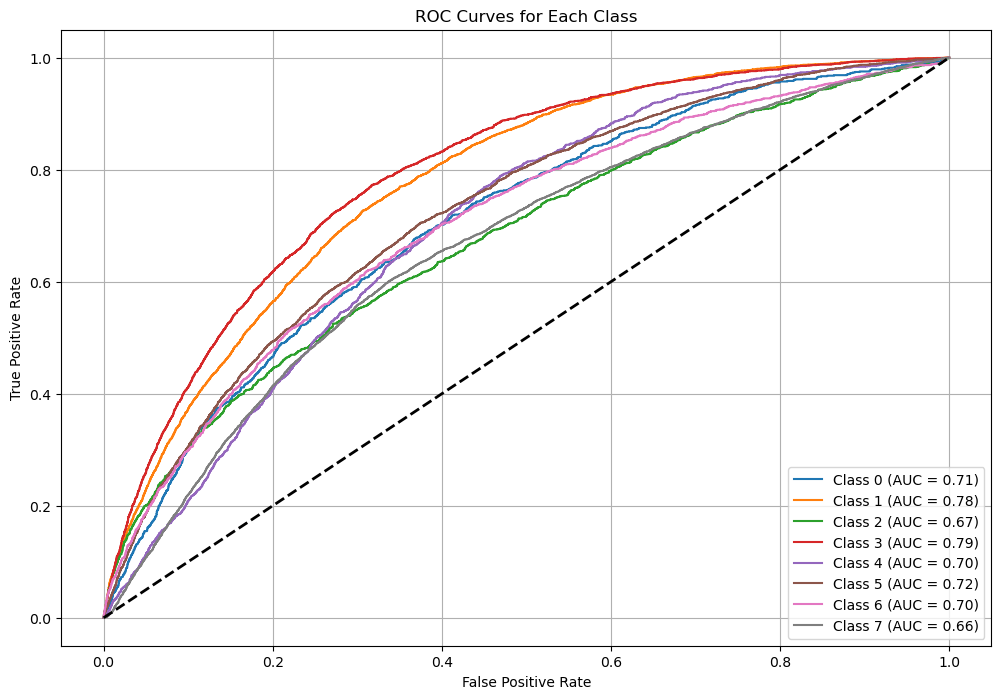

In [24]:
# Convert lists to arrays
logits_array = np.concatenate(logits, axis=0)
labels_array = np.concatenate(labels_list, axis=0)

# Apply sigmoid to get probabilities
probs = torch.sigmoid(torch.tensor(logits_array)).numpy()
preds = (probs > 0.5).astype(int)

# %% [markdown]
# ## Metrics on Test Set

y_true = labels_array.astype(int)
y_pred = preds.astype(int)

print("\nClassification Report (Per-Class):")
print(
    classification_report(
        y_true, y_pred, 
        target_names=[f"Class {i}" for i in range(y_true.shape[1])]
    )
)

# Confusion matrix (argmax at the row level can be misleading for multi-label,
# but shown here for demonstration.)
cm = confusion_matrix(
    y_true.argmax(axis=1), 
    y_pred.argmax(axis=1)
)
print("\nConfusion Matrix:\n", cm)

# Element-wise binary accuracy
correct_predictions = (y_true == y_pred).sum()
total_predictions   = y_true.size
binary_accuracy     = correct_predictions / total_predictions
print(f"Binary Accuracy: {binary_accuracy:.4f}")

# %% [markdown]
# ## ROC Curves (Optional)

plt.figure(figsize=(12, 8))
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [31]:
probs[2]

array([0.8599407 , 0.6993678 , 0.791212  , 0.6181209 , 0.6282311 ,
       0.29099753, 0.94498944, 0.5929762 ], dtype=float32)

In [32]:
y_true[2]

array([0, 0, 0, 1, 0, 0, 0, 0])

In [35]:
for i in range(y_true.shape[1]):
    fpr, tpr, _ = roc_curve(y_true[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

0.7065455600957788
0.7777256822661964
0.6743923381353192
0.7949042880798899
0.6997239908128708
0.7222020393736337
0.7037342695510068
0.6645313273319231
